In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora.dictionary import Dictionary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import sys

In [3]:
XGBClassifier = xgb.XGBClassifier
plot_importance = xgb.plot_importance

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
    
try:
    df = pd.read_csv("Fully_Cleaned_Student_Performance_Data.csv", encoding='cp1252')
except UnicodeDecodeError:
    try:
        df = pd.read_csv("Fully_Cleaned_Student_Performance_Data.csv", encoding='latin1')
    except:
        import chardet
        with open('Fully_Cleaned_Student_Performance_Data.csv', 'rb') as f:
            result = chardet.detect(f.read(100000))
        df = pd.read_csv("Fully_Cleaned_Student_Performance_Data.csv", encoding=result['encoding'])

In [4]:
def preprocess_text(text):
        text = str(text).lower()
        text = text.replace('\x92', "'").replace('\x91', "'")
        text = text.replace('\x93', '"').replace('\x94', '"')
        text = text.replace('…', '...')
        text = text.replace('–', '-').replace('—', '-')
        text = re.sub(r'[^a-zA-Z0-9\'\-\.\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        words = text.split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        return words

In [6]:
df['Cleaned_Feedback'] = df['School_Environment_Feedback'].apply(preprocess_text)

print("Creating n-grams")
bigram = Phrases(df['Cleaned_Feedback'], min_count=5, threshold=10)
trigram = Phrases(bigram[df['Cleaned_Feedback']], threshold=10)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

df['Cleaned_Feedback'] = df['Cleaned_Feedback'].apply(lambda x: trigram_mod[bigram_mod[x]])

Creating n-grams


In [7]:
print("Creating dictionary and corpus")
dictionary = Dictionary(df['Cleaned_Feedback'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df['Cleaned_Feedback']]

Creating dictionary and corpus


In [8]:
    print("Finding optimal topics")
    coherence_scores = []
    topic_range = range(3, 8)

    for num_topics in topic_range:
        model = LdaModel(
            corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            iterations=300,
            random_state=42
        )
        coherence_model = CoherenceModel(
            model=model,
            texts=df['Cleaned_Feedback'],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_scores.append(coherence_model.get_coherence())

    optimal_topics = topic_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics: {optimal_topics}")

    print(f"Training LDA model with {optimal_topics} topics")
    lda_model = LdaModel(
        corpus,
        num_topics=optimal_topics,
        id2word=dictionary,
        passes=15,
        iterations=400,
        random_state=42
    )

Finding optimal topics
Optimal number of topics: 3
Training LDA model with 3 topics


In [9]:
    print("Creating topic features")
    topic_features = []
    for text in df['Cleaned_Feedback']:
        bow = dictionary.doc2bow(text)
        topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
        topic_dist_sorted = sorted(topic_dist, key=lambda x: x[0])
        topic_features.append([prob for _, prob in topic_dist_sorted])

    for i in range(optimal_topics):
        df[f'Topic_{i+1}'] = [vec[i] for vec in topic_features]

    print("Preparing features...")
    features = [
        'Age', 'GWA', 'Attendance_Rate', 'Library_Usage_Hours',
        'Counseling_Sessions'
    ] + [f'Topic_{i+1}' for i in range(optimal_topics)]

Creating topic features
Preparing features...


In [10]:
    categorical_cols = ['Gender', 'Course', 'Year_Level', 'Scholarship_Status']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    report_cols = ['Student_ID', 'Academic_Standing', 'School_Environment_Feedback'] + categorical_cols
    df_report = df[report_cols].copy()

    df = pd.get_dummies(df, columns=categorical_cols)

    features += [col for col in df.columns if any(col.startswith(base + "_") for base in categorical_cols)]

    print("Preparing target variable...")
    le = LabelEncoder()
    df['Academic_Standing_Encoded'] = le.fit_transform(df['Academic_Standing'])

    X = df[features]
    y = df['Academic_Standing_Encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preparing target variable...


In [12]:
    print("Training XGBoost model")
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    print(f"\nXGBoost Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

Training XGBoost model

XGBoost Model Accuracy: 0.9950

Classification Report:
              precision    recall  f1-score   support

Dropout_Risk       1.00      1.00      1.00        52
        Good       0.99      1.00      0.99        83
   Probation       1.00      0.98      0.99        65

    accuracy                           0.99       200
   macro avg       1.00      0.99      1.00       200
weighted avg       1.00      0.99      0.99       200



C:\Users\jerwi\AppData\Local\Temp\ipykernel_31728\1939641968.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

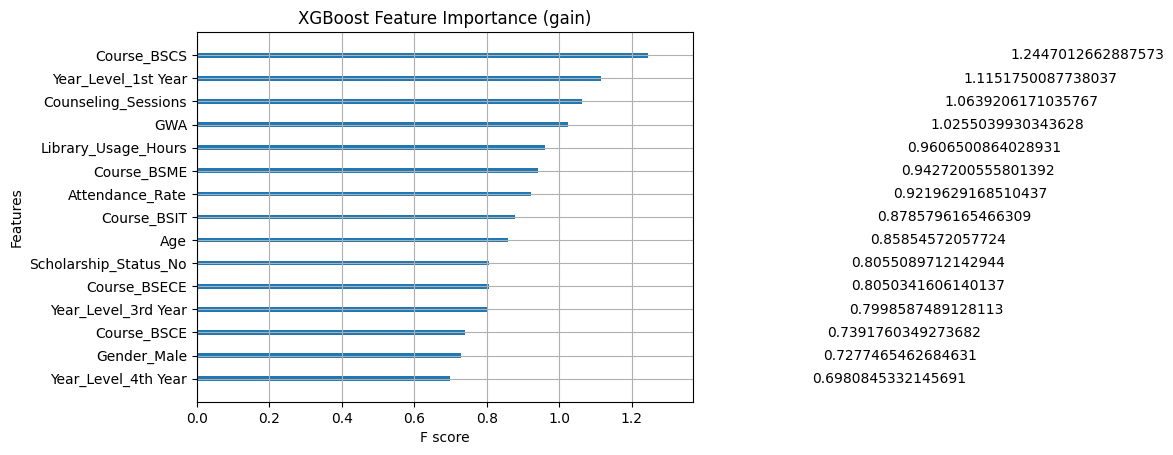

In [13]:
    plt.figure(figsize=(12, 8))
    plot_importance(xgb_model, max_num_features=15, importance_type='gain')
    plt.title("XGBoost Feature Importance (gain)")
    plt.tight_layout()
    plt.savefig('feature_importance_gain.png')
    plt.show()

C:\Users\jerwi\AppData\Local\Temp\ipykernel_31728\1538432671.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


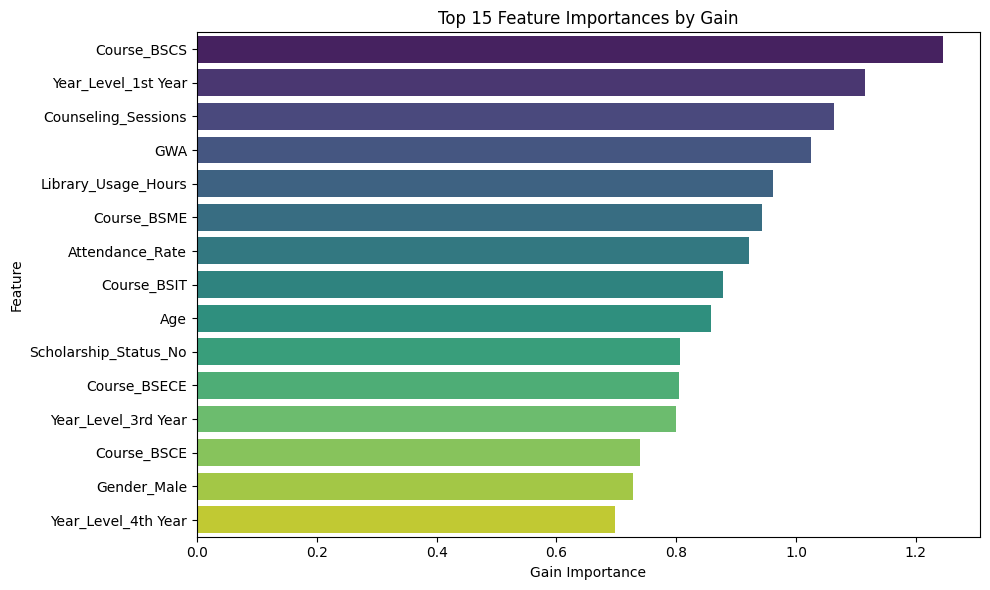

In [14]:
    importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance_gain.keys()),
        'Importance': list(importance_gain.values())
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 15 Feature Importances by Gain')
    plt.xlabel('Gain Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance_barplot.png')
    plt.show()

    conf_matrix = confusion_matrix(y_test, y_pred, labels=le.transform(le.classes_))
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=le.classes_,
        yticklabels=le.classes_
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()

In [15]:
def generate_risk_report(student_id):
        try:
            student = df.iloc[student_id]
            student_report = df_report.iloc[student_id]
            print(f"\n{'='*50}")
            print(f"Risk Report for Student ID: {student_report['Student_ID']}")
            print(f"{'='*50}")
            print(f"Academic Standing: {student_report['Academic_Standing']}")
            print(f"Age: {student['Age']}, Course: {student_report['Course']}, Year: {student_report['Year_Level']}")
            print(f"GWA: {student['GWA']:.2f}, Attendance: {student['Attendance_Rate']:.2f}%")
            print(f"Library Hours: {student['Library_Usage_Hours']:.2f}, Counseling Sessions: {student['Counseling_Sessions']}")

            print("\nTopic Distribution:")
            for i in range(optimal_topics):
                print(f"  Topic {i+1}: {student[f'Topic_{i+1}']:.4f}")

            feedback = student_report['School_Environment_Feedback']
            if len(feedback) > 150:
                feedback = feedback[:147] + "..."
            print(f"\nFeedback Excerpt: {feedback}")

            actual = student_report['Academic_Standing']
            prediction = le.inverse_transform([y_pred[df.index.get_loc(student_id)]])[0]
            print(f"\nPredicted Academic Standing: {prediction} (Actual: {actual})")
            if prediction != actual:
                print("Prediction differs from actual!")
            else:
                print("Prediction matches actual")

        except IndexError:
            print(f"Error: Student ID {student_id} is out of range")

In [18]:
    print("\nLDA Topics:")
    for i in range(optimal_topics):
        topic_words = lda_model.show_topic(i, topn=10)
        words = ", ".join([word for word, _ in topic_words])
        print(f"Topic {i+1}: {words}")
    while True:
        user_input = input("\nEnter student index (0 to {}) for detailed report (or 'exit' to quit): ".format(len(df)-1)).strip()
        if user_input.lower() == 'exit':
            print("Exiting report viewer.")
            break
        if not user_input.isdigit():
            print("Invalid input! Please enter a valid student index or 'exit'.")
            continue
        student_id = int(user_input)
        if 0 <= student_id < len(df):
            generate_risk_report(student_id)
        else:
            print(f"Student index out of range! Please enter a number between 0 and {len(df)-1}.")


    df['Predicted_Academic_Standing'] = le.inverse_transform(xgb_model.predict(X))
    df_final = pd.concat([df_report, df[['Predicted_Academic_Standing']]], axis=1)
    df_final.to_csv('student_predictions.csv', index=False)
    print("\nPredictions saved to student_predictions.csv")


LDA Topics:
Topic 1: computer_labs, program., software_need, equipped_latest, clean_conducive_learning., classrooms_bright, would, students, student, feel
Topic 2: security_guards, friendly_respectful._feel_safe, walking_around_campus., feels_like, second_home, theres_culture_respect_here., welcoming_everyone_is., space_study., library_quiet_comfortable_plenty, events_awareness_weeks.
Topic 3: competitive_supportive., guidance_office, academic_environment, easy_approach_helpful., campus_grounds, clean_well-maintained., restrooms_usually, clean_necessary_supplies., enough, make



Enter student index (0 to 999) for detailed report (or 'exit' to quit):  56



Risk Report for Student ID: S0057
Academic Standing: Good
Age: 24, Course: BSME, Year: 2nd Year
GWA: 4.13, Attendance: 66.24%
Library Hours: 12.11, Counseling Sessions: 3

Topic Distribution:
  Topic 1: 0.8244
  Topic 2: 0.0871
  Topic 3: 0.0885

Feedback Excerpt: We need more visible first aid kits or a dedicated emergency room. Minor injuries often go untreated.

Predicted Academic Standing: Good (Actual: Good)
Prediction matches actual



Enter student index (0 to 999) for detailed report (or 'exit' to quit):  89



Risk Report for Student ID: S0090
Academic Standing: Probation
Age: 21, Course: BSCE, Year: 2nd Year
GWA: 4.49, Attendance: 64.16%
Library Hours: 9.70, Counseling Sessions: 7

Topic Distribution:
  Topic 1: 0.0833
  Topic 2: 0.8333
  Topic 3: 0.0833

Feedback Excerpt: Security guards are friendly and respectful. I feel safe walking around campus.

Predicted Academic Standing: Probation (Actual: Probation)
Prediction matches actual



Enter student index (0 to 999) for detailed report (or 'exit' to quit):  45



Risk Report for Student ID: S0046
Academic Standing: Good
Age: 23, Course: BSIT, Year: 4th Year
GWA: 4.87, Attendance: 86.92%
Library Hours: 16.38, Counseling Sessions: 3

Topic Distribution:
  Topic 1: 0.8667
  Topic 2: 0.0667
  Topic 3: 0.0667

Feedback Excerpt: Our computer labs are equipped with the latest software we need for our program.

Predicted Academic Standing: Probation (Actual: Good)
Prediction differs from actual!



Enter student index (0 to 999) for detailed report (or 'exit' to quit):  exit


Exiting report viewer.

Predictions saved to student_predictions.csv
